In [1]:
%matplotlib inline
import numpy.linalg as la

import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
# Load the data
# Remember to change the file path to your own
ca = nx.Graph()
with open ('ca-CondMat.txt') as f:
    for line in f:
        if line[0] != '#':
            x, y = line.strip().split('\t')
            ca.add_edge(x,y)
nx.info(ca)


'Name: \nType: Graph\nNumber of nodes: 23133\nNumber of edges: 93497\nAverage degree:   8.0834'

In [26]:


def ebks(g, b):
    edge_dict = defaultdict(lambda: defaultdict(int))
    degree_dict = defaultdict(int)
    edge_degree = [sorted(g.degree(e).values()) for e in g.edges()]
    for e in edge_degree:
        edge_dict[e[0]][e[-1]] +=1
    for i in g.degree().values():
        degree_dict[i] +=1
    edge_number = g.number_of_edges()
    node_number = g.number_of_nodes()
    ebks, ks = [], []
    for k1 in edge_dict:
        p1, p2 = 0, 0
        for k2 in edge_dict[k1]:
            if k2 >= b*k1:
                pkk = float(edge_dict[k1][k2])/edge_number
                pk2 = float(degree_dict[k2])/node_number
                k2pk2 = k2*pk2
                p1 += pkk/k2pk2
        for k in degree_dict:
            if k>=b*k1:
                pk = float(degree_dict[k])/node_number
                p2 += pk
        if p2 > 0:
            ebks.append(p1/p2)
            ks.append(k1)
    return ebks, ks

def ebkss(g, b, gamma=2.8):
    edge_dict = defaultdict(lambda: defaultdict(int))
    degree_dict = defaultdict(int)
    edge_degree = [sorted(g.degree(e).values()) for e in g.edges()]
    for e in edge_degree:
        edge_dict[e[0]][e[-1]] +=1
    for i in g.degree().values():
        degree_dict[i] +=1
    edge_number = g.number_of_edges()
    node_number = g.number_of_nodes()
    ebks, ks = [], []
    for k1 in edge_dict:
        p1, p2 = 0, 0
        nk2k = np.sum(edge_dict[k1].values())
        pk1 = float(degree_dict[k1])/node_number
        k1pk1 = k1*pk1
        
        for k2 in edge_dict[k1]:
            if k2 >= b*k1:
                pk2k = float(edge_dict[k1][k2])/edge_number
                pk2 = float(degree_dict[k2])/node_number
                p1 += pk2k/(k2*k2**(-gamma))
#                p1 += pk2k/k2
        for k in degree_dict:
            if k>=b*k1:
                pk = float(degree_dict[k])/node_number
                p2 += pk
        if p2 > 0 and p1 > 0:
            ebks.append(p1/p2)
            ks.append(k1)
    return ebks, ks


def log_binning(x, y, bin_count=50):
    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    xx = [i for i in x if i>0]
    min_x = np.log10(np.min(xx))
    bins = np.logspace(min_x,max_base,num=bin_count)
    hist = np.histogram(x,bins)[0]
    nonzero_mask = np.logical_not(hist==0)       
    hist[hist==0] = 1
    bin_means_y = (np.histogram(x,bins,weights=y)[0] / hist)
    bin_means_x = (np.histogram(x,bins,weights=x)[0] / hist)
    return bin_means_x[nonzero_mask],bin_means_y[nonzero_mask]
def LinearBinData(x, y, number): 
    data=sorted(zip(x,y))
    rs = np.linspace(min(x),max(x),number)
    rs = np.transpose(np.vstack((rs[:-1],rs[1:])))
    ndata = []
    within = []
    for start,end in rs:
        for i,j in data:
            if i>=start and i<end:
                within.append(j)
        ndata.append([(start+end)/2.0,np.mean(np.array(within))]  )
    nx,ny = np.array(ndata).T
    return nx,ny

In [3]:

def get_logslope(x,y):
    A = np.empty((len(x), 2))
    A[:,0] = np.log(x)
    A[:,1] = 1
#     print A
    res = la.lstsq(A, np.log(y))
    return res[0][0]

def show_eb(ca, b, gamma):
    #calculate ebk 
    ebk, k = ebkss(ca, b=b,gamma=gamma)
    print "Slope = ", get_logslope(np.array(k), np.array(ebk) )
    lebk, lk = log_binning(np.array(k), np.array(ebk))
    print "Other Slope", getlogslope(lk, lebk)
    plt.plot(k,ebk,'r^')
    plt.xlabel(r'$k$', fontsize = 16)
    plt.ylabel(r'$E_b(k)$', fontsize = 16)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
# show_eb(ca, 3, 2.8)

In [6]:
# import powerlaw
# res = powerlaw.Fit(np.array(ca.degree().values()))
# print res.alpha
# print res.xmin
ebk, k = ebkss(ca, b=3,gamma=2.8)

In [61]:
#print "Hi"
print get_logslope(np.array(k), np.array(ebk))


[ 1.22136716  3.529074  ]


In [12]:
import powerlaw
res = powerlaw.Fit(np.array(ca.degree().values())+1, xmin=10)
print res.alpha
print res.xmin

2.84571139756
10.0


In [7]:
ddict = defaultdict(int)
for n in ca.degree().values():
        ddict[n]+=1
l = []        
inds = []
for i in xrange(31,281):
    if ddict[i] > 0:
        inds.append(i)
        l.append(ddict[i])
print get_logslope(np.array(inds),np.array(l))

-2.39394748995


In [4]:
def hack_gml_read(fname):
  g = nx.Graph()
  with open(fname, "r") as f:
    lsource = None
    for line in f:
      arr = line.strip().split(" ")
      if not len(arr): continue
      if arr[0] == "source":
        lsource = int(arr[1])
      elif arr[0] == "target":
        g.add_edge(lsource, int(arr[1]))
  return g

def single_line_read(fname):    
    g = nx.Graph()
    with open(fname, "r") as f:
        for line in f:
          a = map(int,line.strip().split(" "))
          g.add_edge(a[0], a[1])
    return g

#internet = hack_gml_read("data/as-22july06.gml")
www = single_line_read("data/www.dat")

In [5]:
nx.info(www)

'Name: \nType: Graph\nNumber of nodes: 325729\nNumber of edges: 1117563\nAverage degree:   6.8619'

In [ ]:
ebk, k = ebks(www, 3)

In [ ]:
#print np.array(ebk)
lk, lebk = log_binning(np.array(k,dtype=np.float64), np.array(ebk))
print lk, lebk
def log_plot(ebk, k):
    lebk, lk = log_binning(np.array(k), np.array(ebk))
    print "Other Slope", get_logslope(lk, lebk)
    plt.plot(k,ebk,'r^')
    plt.xlabel(r'$k$', fontsize = 16)
    plt.ylabel(r'$E_b(k)$', fontsize = 16)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
#log_plot(ebk,k)

Slope 0.162453554297


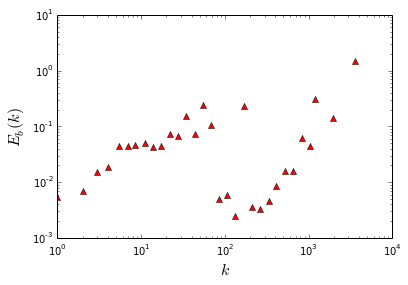

In [31]:
lk, lebk = log_binning(np.array(k,dtype=np.float64), np.array(ebk), bin_count=70)
#print lk, lebk
print "Slope", get_logslope(lk, lebk)
plt.plot(lk,lebk/www.number_of_edges(),'r^')
plt.xlabel(r'$k$', fontsize = 16)
plt.ylabel(r'$E_b(k)$', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.show()
